In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import random
import bisect
import re
import numpy as np


from collections import defaultdict
from collections import Counter
import random
import sys
import pickle

sys.path.insert(0,'../decryption')
sys.path.insert(0,'../encryption')
sys.path.insert(0,'../dictionaries')

import encrypt
import decrypt
import alphabet
import frequency

_ALPHABET = " abcdefghijklmnopqrstuvwxyz"

In [2]:
# simulation of problem
TEST_KEY_MAPPING = encrypt.generate_key_mapping()
TEST_CHAR_MAPPING = encrypt.char_key_mapping_from_key_mapping(TEST_KEY_MAPPING)

assert len(set(TEST_KEY_MAPPING)) == 27

TEST_PLAIN_TEXTS = []
with open('../dictionaries/official_dictionary_1_cleaned.txt','r') as f:
    content = f.readlines()
    for line in content:
        TEST_PLAIN_TEXTS.append(line.strip())

TEST_PLAIN_TEXTS[3] += ' '
TEST_PROBABILITY = 0.1
ciphers = [encrypt.encrypt(msg,TEST_KEY_MAPPING,TEST_PROBABILITY) for msg in TEST_PLAIN_TEXTS]

# pick a random cipher and start working with it. (We should not know the original plain text)
r = random.randint(0,len(ciphers)-1)
cipher_txt = ciphers[r]
test_plain_text = TEST_PLAIN_TEXTS[r]

In [3]:
with open('../dictionaries/official_dictionary_2_cleaned.txt') as file:
    lines = file.readlines()

DICTIONARY_LIST = []
DICTIONARY_SET = set()

for line in lines:
    line = re.sub('[^A-Za-z0-9]+', '', line.strip())
    DICTIONARY_LIST.append(line)
    DICTIONARY_SET.add(line)

In [4]:
def generate_test_one_cipher(p):
    num_key_mapping = encrypt.generate_key_mapping()
    char_key_mapping = encrypt.char_key_mapping_from_key_mapping(num_key_mapping)
    r = random.randint(0,len(ciphers)-1)
    cipher = encrypt.encrypt(TEST_PLAIN_TEXTS[r],num_key_mapping,p)
    return TEST_PLAIN_TEXTS[r],cipher,char_key_mapping,num_key_mapping

def generate_test_two_cipher(p):
    num_key_mapping = encrypt.generate_key_mapping()
    char_key_mapping = encrypt.char_key_mapping_from_key_mapping(num_key_mapping)
    plain_txt = " ".join(random.choices(DICTIONARY_LIST,k=200))[:500]
    cipher = encrypt.encrypt(plain_txt,num_key_mapping,p)
    return plain_txt,cipher,char_key_mapping,num_key_mapping
    

In [6]:
plain_txt,cipher,char_key_mapping,num_key_mapping = generate_test_two_cipher(0.2)

In [21]:
def build_rel_dist(text):
    rel_dist = defaultdict(list)
    rel_num = defaultdict(list)
    for j,c in enumerate(text):
        rel_dist[c].append((j/len(text)))
        rel_num[c].append(j)
    return rel_dist,rel_num

def get_diff(arr):
    diff = []
    for i in range(1,len(arr)):
        diff.append(round(arr[i]-arr[i-1],4))
    return diff

def get_char_diffs_data(char_rel_num,rel_num,l):
    left = []
    right = []
    avg_num_diff = []
    for i,num in enumerate(rel_num):
        char_closest_right = bisect.bisect_left(char_rel_num,num)
        char_closest_left = char_closest_right-1
        if char_closest_left == -1:
            lo = 0
        else:
            lo = char_rel_num[char_closest_left]
        if char_closest_right == len(char_rel_num):
            hi = l
        else:
            hi = char_rel_num[char_closest_right]
        left.append(num-lo)
        right.append(hi-num)
        avg_num_diff.append(right[-1] - left[-1])
        
    return left,right,avg_num_diff

def append(data,df):
    l = len(df)
    for k,v in data.items():
        df.loc[l,k] = v
        
def populate_dist_data(dist,prefix,data = dict()):
    data[prefix + '_mean'] = np.mean(dist)
    data[prefix + '_std'] = np.std(dist)
    
    max_moments = 3
    for i in range(2,max_moments+1):
        data[prefix+str(i)+'_num_moment'] = stats.moment(dist,i)
    
    return data

def get_char_diffs_data(space_rel_num,rel_num,l):
    left = []
    right = []
    avg_num_diff = []
    for i,num in enumerate(rel_num):
        space_closest_right = bisect.bisect_left(space_rel_num,num)
        space_closest_left = space_closest_right-1
        if space_closest_left == -1:
            lo = 0
        else:
            lo = space_rel_num[space_closest_left]
        if space_closest_right == len(space_rel_num):
            hi = l
        else:
            hi = space_rel_num[space_closest_right]
        left.append(num-lo)
        right.append(hi-num)
        avg_num_diff.append(right[-1] - left[-1])
        
    return left,right,avg_num_diff


# features: space character frequency, last character frequency, difference from 500
# stats of space char freq diff, last char freq diff
# stats of char diffs data of last char and space char
# covariance of space char and last char data

def get_test_diff_data(cipher,c_rel_num,c_rel_num_diff,space_char,space_last_char_rel,last_char_mapping):
    data = dict()
    data['space_char_freq'] = len(c_rel_num[space_char])
    data['last_char_freq'] = len(c_rel_num[last_char_mapping])
    data['diff'] = len(cipher) - 500
    
    left,right,avg_num_diff = space_last_char_rel

    populate_dist_data(left,'left_space_last_char',data)
    populate_dist_data(right,'right_space_last_char',data)
    populate_dist_data(avg_num_diff,'avg_space_last_char',data)
    
    populate_dist_data(c_rel_num_diff[space_char],'space_diff',data)
    populate_dist_data(c_rel_num_diff[last_char_mapping],'last_char_diff',data)

    l = min(len(c_rel_num[space_char]),len(c_rel_num[last_char_mapping]))
    if l>1:
        data['last_space_num_first_cov'] = np.cov(c_rel_num[space_char][:l],c_rel_num[last_char_mapping][:l])[0][1]
    return data
    

In [22]:
# get distributions for cipher
c_rel_dist,c_rel_num = build_rel_dist(cipher)
c_rel_num_diff = defaultdict(list,{k:get_diff(v) for k,v in c_rel_num.items()})
c_rel_dist_diff = defaultdict(list,{k:get_diff(v) for k,v in c_rel_dist.items()})

space_char = decrypt.get_space_key_value(cipher)
space_data_c = defaultdict(list,{c:get_char_diffs_data(c_rel_num[space_char],c_rel_num[c],len(cipher)) for c in _ALPHABET})

last_char_mapping = cipher[-1]
last_char_data_c = defaultdict(list,{c:get_char_diffs_data(c_rel_num[last_char_mapping],c_rel_num[c],len(cipher)) for c in _ALPHABET})
    

In [31]:
cols = ['space_char_freq',
 'last_char_freq',
 'diff',
 'left_space_last_char_mean',
 'left_space_last_char_std',
 'left_space_last_char2_num_moment',
 'left_space_last_char3_num_moment',
 'right_space_last_char_mean',
 'right_space_last_char_std',
 'right_space_last_char2_num_moment',
 'right_space_last_char3_num_moment',
 'avg_space_last_char_mean',
 'avg_space_last_char_std',
 'avg_space_last_char2_num_moment',
 'avg_space_last_char3_num_moment',
 'space_diff_mean',
 'space_diff_std',
 'space_diff2_num_moment',
 'space_diff3_num_moment',
 'last_char_diff_mean',
 'last_char_diff_std',
 'last_char_diff2_num_moment',
 'last_char_diff3_num_moment',
 'last_space_num_first_cov',
 'result'
       ]

In [32]:
def iter_tests(p,num):
    for _ in range(num):
        plain_txt,cipher,char_key_mapping,num_key_mapping = generate_test_one_cipher(p)
        yield plain_txt,cipher,char_key_mapping,num_key_mapping,True
        
        plain_txt,cipher,char_key_mapping,num_key_mapping = generate_test_two_cipher(p)
        yield plain_txt,cipher,char_key_mapping,num_key_mapping,False

def iter_prob_tests(pmin,pmax,step,num):
    for prob in range(pmin,pmax+1,step):
        print('generating for prob',prob)
        for plain_txt,cipher,char_key_mapping,num_key_mapping,result in iter_tests(prob/100,num):
            yield plain_txt,cipher,char_key_mapping,num_key_mapping,result

In [78]:
num_feat

24

In [33]:
df = pd.DataFrame(columns = cols)
for plain_txt,cipher,char_key_mapping,num_key_mapping,result in iter_prob_tests(1,70,1,1000):
    # get distributions for cipher
    c_rel_dist,c_rel_num = build_rel_dist(cipher)
    c_rel_num_diff = defaultdict(list,{k:get_diff(v) for k,v in c_rel_num.items()})
    c_rel_dist_diff = defaultdict(list,{k:get_diff(v) for k,v in c_rel_dist.items()})

    space_char = decrypt.get_space_key_value(cipher)
    space_data_c = defaultdict(list,{c:get_char_diffs_data(c_rel_num[space_char],c_rel_num[c],len(cipher)) for c in _ALPHABET})

    last_char_mapping = cipher[-1]
    last_char_data_c = defaultdict(list,{c:get_char_diffs_data(c_rel_num[last_char_mapping],c_rel_num[c],len(cipher)) for c in _ALPHABET})
    
    data = get_test_diff_data(cipher,c_rel_num,c_rel_num_diff,space_char,space_data_c[last_char_mapping],last_char_mapping)
    data['result'] = result
    
    append(data,df)
    
    

generating for prob 1
generating for prob 2
generating for prob 3


/Users/adityachawla/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/adityachawla/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/adityachawla/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/adityachawla/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/adityachawla/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


generating for prob 4
generating for prob 5
generating for prob 6
generating for prob 7
generating for prob 8
generating for prob 9
generating for prob 10
generating for prob 11
generating for prob 12
generating for prob 13
generating for prob 14
generating for prob 15
generating for prob 16
generating for prob 17
generating for prob 18
generating for prob 19
generating for prob 20
generating for prob 21
generating for prob 22
generating for prob 23
generating for prob 24
generating for prob 25
generating for prob 26
generating for prob 27
generating for prob 28
generating for prob 29
generating for prob 30
generating for prob 31
generating for prob 32
generating for prob 33
generating for prob 34
generating for prob 35
generating for prob 36
generating for prob 37
generating for prob 38
generating for prob 39
generating for prob 40
generating for prob 41
generating for prob 42
generating for prob 43
generating for prob 44
generating for prob 45
generating for prob 46
generating for pr

In [34]:
df = df.fillna(0)

In [35]:
# build a model
import torch
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [36]:
output_idx = list(df.columns).index('result')
input_cols = list(df.columns)
input_cols.remove('result')
X = df.loc[:,input_cols].values
y = df.iloc[:,output_idx].values.reshape(-1,1).astype(np.float64)


X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.20)
num_feat = X_train_raw.shape[1]

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = torch.from_numpy(scaler.transform(X_train_raw)).float()
X_test = torch.from_numpy(scaler.transform(X_test_raw)).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [37]:
train_dataset = TensorDataset(X_train,y_train) # create your datset
train_dataloader = DataLoader(train_dataset,batch_size=16,shuffle=True) # create your dataloader

test_dataset = TensorDataset(X_test,y_test) # create your datset
test_dataloader = DataLoader(test_dataset,batch_size=16,shuffle=True) # create your dataloader

In [38]:
num_feat = len(X_train[0])

In [66]:

class NeuralNet(torch.nn.Module): 
    def __init__(self):
        super(NeuralNet,self).__init__()

        self.relu = torch.nn.ReLU()
        
        self.lin1 = torch.nn.Linear(num_feat, 16)
        
        self.lin2 =torch.nn.Linear(16, 64)
        
        self.lin3 =torch.nn.Linear(64, 16)
        
        self.lin4 =torch.nn.Linear(16, 1)
        
        self.out = torch.nn.Sigmoid()
        
        self.float()
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.relu(x)
        
        x = self.lin2(x)
        x = self.relu(x)
        
        x = self.lin3(x)
        x = self.relu(x)
        
        x = self.lin4(x)
        x = self.out(x)
        
        return x

net = NeuralNet()
loss = torch.nn.BCELoss() # pass output, target
optimizer = torch.optim.Adam(net.parameters(), lr=0.002)


In [67]:
train_loss_history = []
test_loss_history = []

In [69]:
epochs = 300
for epoch in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    for i, data in enumerate(train_dataloader):
        net.train()
        a_inp, a_out = data
        optimizer.zero_grad()
        predicted_output = net(a_inp)
        fit = loss(predicted_output,a_out) # loss(p_out,a_out)
        fit.backward()
        optimizer.step()
        train_loss += fit.item()

    for i, data in enumerate(test_dataloader):
        net.eval()
        with torch.no_grad():
            a_inp, a_out = data
            predicted_output = net(a_inp)
            fit = loss(predicted_output,a_out)
            test_loss += fit.item()
            predicted = torch.max(predicted_output.data, 1)

    train_loss = train_loss/len(train_dataloader)
    test_loss = test_loss/len(test_dataloader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    if test_loss<0.19:
        break
    print('Epoch %s, Train loss %s, Test loss %s'%(epoch, train_loss, test_loss))

Epoch 0, Train loss 0.26183948414480046, Test loss 0.26510751741273064
Epoch 1, Train loss 0.24339240580830457, Test loss 0.23582622994642172
Epoch 2, Train loss 0.235459083236887, Test loss 0.23034603090052094
Epoch 3, Train loss 0.22997259652135627, Test loss 0.23121373332504716
Epoch 4, Train loss 0.22568843626869575, Test loss 0.23364825777027623
Epoch 5, Train loss 0.22227977272229535, Test loss 0.2328138432119574
Epoch 6, Train loss 0.21993646363774313, Test loss 0.21889383700915746
Epoch 7, Train loss 0.21788783316068086, Test loss 0.22299637187219093
Epoch 8, Train loss 0.21535807949540736, Test loss 0.21298258961417846
Epoch 9, Train loss 0.21339380254589818, Test loss 0.21303685386106372
Epoch 10, Train loss 0.21170517873567796, Test loss 0.214719663039382
Epoch 11, Train loss 0.2106676003944927, Test loss 0.2149662454854697
Epoch 12, Train loss 0.20951324472702773, Test loss 0.2050360806011595
Epoch 13, Train loss 0.207990244376074, Test loss 0.21077628934064083
Epoch 14, Tr

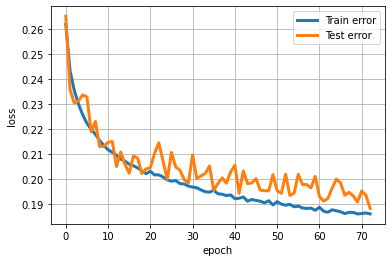

In [70]:
plt.plot(range(len(train_loss_history)),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(len(test_loss_history)),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [76]:
correct = 0
total = 0

net.eval()
for i, data in enumerate(test_dataloader):
    with torch.no_grad():
        a_inp, a_out = data
        predicted_output = net(a_inp)
        p_arr = predicted_output.detach().numpy()
        a_out = a_out.detach().numpy()
        for i in range(len(a_out)):
            if abs(p_arr[i] - a_out[i])<0.5:
                correct += 1
            total += 1

print('accuracy is',correct/total)

accuracy is 0.9148214285714286


In [77]:
import pickle
cols_one = input_cols
with open('columns_diff_test_2.pkl', 'wb') as handle:
    pickle.dump(cols_one, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('scaler_diff_test_2.pkl', 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
torch.save(net.state_dict(),'model_diff_test_2.state')

In [5]:
import os

In [75]:
import torch
with open('columns_diff_test.pkl', 'rb') as handle:
    cols_diff = pickle.load(handle)
    
scaler_diff = None
with open('scaler_diff_test.pkl', 'rb') as handle:
    scaler_diff = pickle.load(handle)

class DiffNeuralNet(torch.nn.Module): 
    def __init__(self):
        super(DiffNeuralNet,self).__init__()

        self.relu = torch.nn.ReLU()
        
        self.lin1 = torch.nn.Linear(12, 16)
        
        self.lin2 =torch.nn.Linear(16, 64)
        
        self.lin3 =torch.nn.Linear(64, 16)
        
        self.lin4 =torch.nn.Linear(16, 1)
        
        self.out = torch.nn.Sigmoid()
        
        self.float()
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.relu(x)
        
        x = self.lin2(x)
        x = self.relu(x)
        
        x = self.lin3(x)
        x = self.relu(x)
        
        x = self.lin4(x)
        x = self.out(x)
        
        return x
    
diff_net = DiffNeuralNet()
diff_net.load_state_dict(torch.load('model_diff_test.state'))

<All keys matched successfully>

In [6]:
plain_txt,cipher,char_key_mapping,num_key_mapping = generate_test_two_cipher(0.2)

In [7]:
space_char = decrypt.get_space_key_value(cipher)


In [19]:
word_candidates_raw = cipher.split('h')
word_candidates = []
l = len(word_candidates_raw)
n = 2
for i in range(l):
    word = word_candidates_raw[i]
    itr=0
    while itr<n and i+itr<=l:
        word_candidates.append(word + "".join(word_candidates_raw[i:i+itr]))
        itr += 1

In [26]:
with open("../dictionaries/official_dictionary_2_cleaned.txt", "r") as f:
    dictionary = [line.rstrip() for line in f]

In [27]:
def get_longest_common_subsequence(w1, w2):
    dp = [[0 for _ in range(len(w1) + 1)] for _ in range(len(w2) + 1)]
    
    for i in range(1, len(w2) + 1):
        for j in range(1, len(w1) + 1):
            c1, c2 = w2[i - 1], w1[j - 1]
            x = int(c1 == c2)
            dp[i][j] = max(dp[i][j - 1], dp[i - 1][j - 1] + x, dp[i - 1][j])
            
    res = []
    k = len(dp[-1]) - 1
    for i in reversed(range(len(dp) - 1)):
        j = i + 1
        if dp[i][k] == dp[j][k]:
            continue
        while k >= 0 and dp[i][k] < dp[j][k]:
            k -= 1
        if k >= 0:
            res.append(w1[k])
            
    return "".join(reversed(res))

def split_t2_ciphertext(cipher, dictionary):
    space_c = decrypt.get_space_key_value(cipher)
    #print("The space key returned by the algorithm is: " + space_c)
    #print("The correct space key is: " + ALPHABET[KEY[0]])
    
    words = []
    i = j = 0
    lengths = sorted(list(len(w) for w in dictionary), reverse=True)
    min_len = lengths[-1]
    # The minimum length of a word in the dictionary
    
    while i < len(cipher):
        if cipher[i] == space_c and i - j + 1 < min_len:
            i += 1
            continue
            
        if cipher[i] == space_c:
            w = cipher[j : i]
            words.append(w)
            j = i + 1
        
        i += 1
        
    if i > j:
        words.append(cipher[j:i])
        
    return sorted(words, key=lambda w: len(w), reverse=True)


def find_matches_for_duplicates(words, dictionary):
    res = set()
    h = {w: True for w in dictionary}
    
    for i in range(len(words)):
        for j in range(i + 1, len(words)):
            seq = get_longest_common_subsequence(words[i], words[j])
            for w in h:
                if len(w) == len(seq):
                    res.add((w, seq))
                    
    return sorted(list(res), key=lambda x: len(x[0]), reverse=True)

def map_char_in_duplicates(matches, ciphertext):
    cnt = [0] * len(matches)
    for i, (p, c) in enumerate(matches):
        mapping = {x: y for x in c for y in p}
        for j, (p2, c2) in enumerate(matches):
            if j == i:
                continue
            
            dec = []
            for x in c2:
                if x in mapping:
                    dec.append(mapping[x])
                else:
                    dec.append(x)
            
            dec = "".join(dec)
            seq = get_longest_common_subsequence(p2, dec)
            cnt[i] += len(seq)
            
    for i in range(len(cnt)):
        cnt[i] = [i, cnt[i]]
           
    cnt.sort(key=lambda x: x[1], reverse=True)
    #print(cnt)
    
    space_c = decrypt.get_space_key_value(ciphertext)
    
    m = {space_c: " "}
    i = 0
    while len(m) < 27 and i < len(cnt):
        j = cnt[i][0]
        p, c = matches[i]
        for k, x in enumerate(c):
            if x in m:
                continue
            m[x] = p[k]
        
        i += 1
        
    all_decrypted = []
    for p, c in matches:
        d = "".join([m[x] for x in c])
        all_decrypted.append([p, c, d])
        
    #print(all_decrypted)
    
    return m



In [29]:
rand_p = 0.2
round_cnt = 1

In [34]:
plain_txt,cipher,char_key_mapping,num_key_mapping = generate_test_two_cipher(rand_p)

In [41]:
keys = num_key_mapping
t2_plain = plaintext = plain_txt
t2_cipher = ciphertext = cipher

words = split_t2_ciphertext(t2_cipher, dictionary)
matches = find_matches_for_duplicates(words, dictionary)
m = mapping = map_char_in_duplicates(matches, t2_cipher)

In [43]:
t2_dec = []
for x in ciphertext:
    if x not in mapping:
        continue
    t2_dec.append(mapping[x])

t2_dec = "".join(t2_dec)
#print(t2_dec)

dec_words = t2_dec.split(" ")
dec_2 = []

for w in dec_words:
    all_len = []
    for w2 in dictionary:
        seq = get_longest_common_subsequence(w, w2)
        all_len.append((w2, len(seq)))

    all_len.sort(key=lambda x: x[1], reverse=True)
    dec_2.append(all_len[0][0])

final_dec = " ".join(dec_2)
#print("\n\nFinal decrypted text: ")
#print(final_dec)
#print("\n\nOriginal plaintext: ")
#print(t2_plain)

seq = get_longest_common_subsequence(final_dec, plaintext)
acc = len(seq) / len(plaintext)
#print("\n\nAccuracy: " + str(acc))

In [45]:
final_dec

'brickyard invalided blistered leaseback particulate twirlier favouring invalided assurers freaking brickyard leaseback overachiever overachiever overachiever brickyard overachiever changeover changeover overachiever overachiever overachiever changeover changeover brickyard overachiever brickyard brickyard brickyard blistered overachiever overachiever brickyard overachiever assurers alefs overachiever overachiever overachiever brickyard farcer invalided overachiever clarence leaseback freaking outflanked brickyard brickyard alefs clarence clarence overachiever freaking clarence freaking alefs brickyard clarence overachiever changeover changeover'